In [3]:
# Import necessary libraries
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import yfinance as yf  # To fetch stock data from Yahoo Finance
import torch  # Main PyTorch library
import torch.nn as nn  # For neural network components
import torch.optim as optim  # For optimization algorithms
from sklearn.preprocessing import MinMaxScaler  # For data normalization
from torch.utils.data import DataLoader, Dataset  # For handling data in batches


In [4]:
# Parameters for stock data fetching
stock_symbol = 'AAPL'  # Example: Apple Inc. stock symbol
start_date = '2010-01-01'  # Start date for fetching data
end_date = '2023-01-01'  # End date for fetching data

# Fetch stock data from Yahoo Finance
data = yf.download(stock_symbol, start=start_date, end=end_date)

# Display the first few rows of the data
print(data.head())


[*********************100%***********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.454506  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.465666  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.362820  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.351057  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.393281  447610800


In [5]:
# Use the 'Close' price for prediction (the price we want to predict)
data = data[['Close']]

# Normalize the data to the range [0, 1]
# This helps improve convergence during training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences of data for LSTM
def create_sequences(data, seq_length):
    """
    Create sequences of the specified length for training.
    
    Args:
        data: The input data (normalized).
        seq_length: The length of the sequences to create.

    Returns:
        sequences: A list of sequences.
        labels: Corresponding labels (the next value after each sequence).
    """
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])  # Add sequence
        labels.append(data[i + seq_length])  # Add label (next value)
    return np.array(sequences), np.array(labels)

# Parameters for sequence creation
seq_length = 30  # Number of previous days to use for prediction
X, y = create_sequences(scaled_data, seq_length)  # Create sequences and labels

# Split into training and test sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)  # 80% of the data for training
X_train, X_test = X[:train_size], X[train_size:]  # Split sequences
y_train, y_test = y[:train_size], y[train_size:]  # Split labels

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)  # Convert sequences to tensor
y_train_tensor = torch.FloatTensor(y_train)  # Convert labels to tensor
X_test_tensor = torch.FloatTensor(X_test)  # Convert test sequences to tensor
y_test_tensor = torch.FloatTensor(y_test)  # Convert test labels to tensor


In [6]:
class LSTMModel(nn.Module):
    """
    LSTM Model for Time Series Forecasting.
    """
    def __init__(self, input_size, hidden_size, num_layers):
        """
        Initialize the LSTM model.

        Args:
            input_size: Number of input features.
            hidden_size: Number of hidden neurons in the LSTM.
            num_layers: Number of LSTM layers.
        """
        super(LSTMModel, self).__init__()  # Call parent class initializer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # LSTM layer
        self.fc = nn.Linear(hidden_size, 1)  # Fully connected layer for output

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x: Input tensor.

        Returns:
            Output tensor from the model.
        """
        out, _ = self.lstm(x)  # Pass input through LSTM layer
        out = self.fc(out[:, -1, :])  # Get output from the last time step
        return out

# Hyperparameters for the model
input_size = 1  # Number of features (1 for closing price)
hidden_size = 50  # Number of hidden neurons
num_layers = 2  # Number of LSTM layers
num_epochs = 50  # Number of training epochs
learning_rate = 0.001  # Learning rate for optimizer
batch_size = 32  # Batch size for training

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers).float()  # Create an instance of the model


In [7]:
# Define loss function
criterion = nn.MSELoss()  # Mean Squared Error loss for regression tasks

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer


In [8]:
# Create DataLoader for training data to handle batches
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)  # Create dataset
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)  # Create DataLoader

# Training loop
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(inputs)  # Get model predictions
        loss = criterion(outputs, labels)  # Calculate loss
        
        # Backward and optimize
        loss.backward()  # Backpropagation to compute gradients
        optimizer.step()  # Update model parameters

    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/50], Loss: 0.0000
Epoch [20/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0000
Epoch [40/50], Loss: 0.0000
Epoch [50/50], Loss: 0.0000


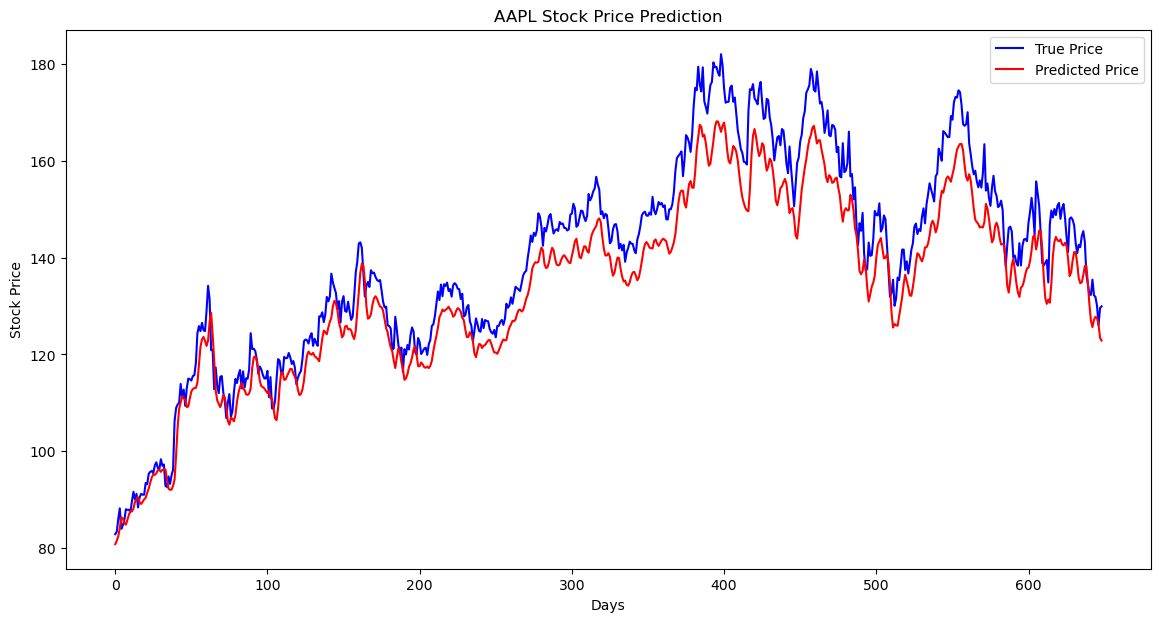

In [9]:
# Switch the model to evaluation mode
model.eval()

# Predict on the test set
with torch.no_grad():  # No need to compute gradients during evaluation
    y_pred = model(X_test_tensor)  # Get predictions

# Inverse transform the predictions to original scale (from normalized to actual prices)
y_pred_inv = scaler.inverse_transform(y_pred.numpy())  # Inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test_tensor.numpy())  # Inverse transform true labels

# Plot the results to visualize predictions vs true prices
plt.figure(figsize=(14, 7))  # Set figure size
plt.plot(y_test_inv, label='True Price', color='blue')  # True prices
plt.plot(y_pred_inv, label='Predicted Price', color='red')  # Predicted prices
plt.title(f'{stock_symbol} Stock Price Prediction')  # Title of the plot
plt.xlabel('Days')  # X-axis label
plt.ylabel('Stock Price')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot


In [10]:
# Practical testing
# Parameters for stock data fetching
nstock_symbol = 'AAPL'  # Example: Apple Inc. stock symbol
nstart_date = '2010-01-01'  # Start date for fetching data
nend_date = None  # End date for fetching data

# Fetch stock data from Yahoo Finance
ndata = yf.download(nstock_symbol, start=nstart_date, end=nend_date)
# Use the 'Close' price for prediction (the price we want to predict)
ndata = ndata[['Close']]

# Normalize the data to the range [0, 1]
# This helps improve convergence during training
nscaler = MinMaxScaler(feature_range=(0, 1))
nscaled_data = scaler.fit_transform(ndata)
nscaled_data

[*********************100%***********************]  1 of 1 completed


array([[0.00343772],
       [0.00349564],
       [0.00296183],
       ...,
       [0.98588592],
       [0.9875077 ],
       [1.        ]])

In [12]:
nX = np.array([nscaled_data])
nX_tensor = torch.FloatTensor(nX)
with torch.no_grad():  # No need to compute gradients during evaluation
    ny_pred = model(nX_tensor)  # Get predictions
ny_pred_inv = scaler.inverse_transform(ny_pred.numpy())
print(ny_pred_inv)

[[217.47115]]


In [14]:
# Save the trained model to a file
model_path = '../models/basic_lstm_stock_model.pt'  # Path to save the model
scripted_model = torch.jit.script(model)  # Create a scripted version of the model
scripted_model.save(model_path)  # Save the scripted model